### Demonstration with pre-trained models


In [73]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from dataset import SequenceDatasetCNN
from model import LSTM, Convolutional, FeedForward
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from utils import plot_pred_target, step_by_step

In [74]:
model_type = "cnn"

df = pd.read_csv(f"data/{model_type}.csv")

df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)


df.head()

,consumption,temperature
timestamp,,
2017-05-01 00:00:00+00:00,2674.838,5.5
2017-05-01 01:00:00+00:00,2678.188,4.0
2017-05-01 02:00:00+00:00,2678.341,3.7
2017-05-01 03:00:00+00:00,2684.172,3.2
2017-05-01 04:00:00+00:00,2733.345,2.7


### Split data


In [75]:
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)

### Normalize


In [76]:
train_mean = df_train.mean()
train_std = df_train.std()

df_test = (df_test - train_mean) / train_std

df_test.head()

,consumption,temperature
timestamp,,
2023-05-02 09:00:00+00:00,0.170499,-0.323805
2023-05-02 10:00:00+00:00,0.126064,-0.040133
2023-05-02 11:00:00+00:00,0.104119,-0.259334
2023-05-02 12:00:00+00:00,0.080581,-0.078815
2023-05-02 13:00:00+00:00,0.055031,0.037233


### Load pre-trained model


In [77]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

model = (
    FeedForward()
    if model_type == "fnn"
    else Convolutional(tw=100)
    if model_type == "cnn"
    else LSTM(device=device)
    if model_type == "lstm"
    else None
)

model.to(device)

model.load_state_dict(torch.load(f"models/{model_type}.pth"))
model.eval()

Convolutional(
  (conv_stack): Sequential(
    (0): Conv1d(100, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): LeakyReLU(negative_slope=0.2)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): LeakyReLU(negative_slope=0.2)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_stack): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

### Testing and plotting comparison


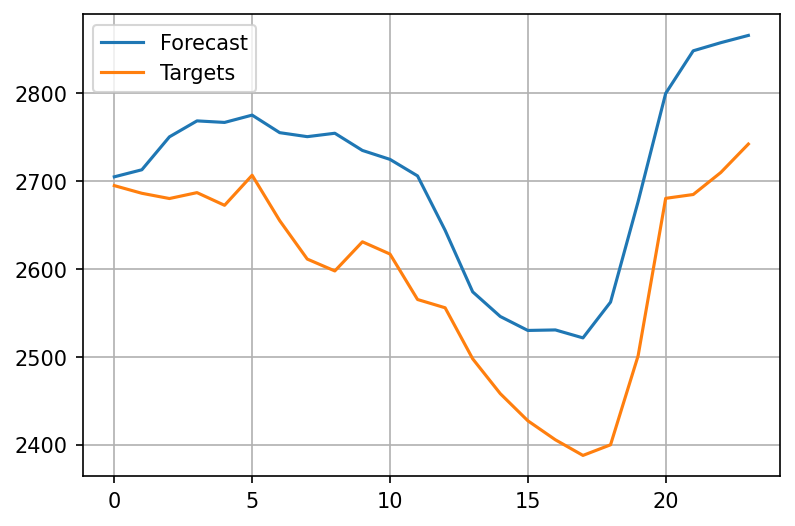

In [78]:
if model_type == "fnn":
    features_test = torch.tensor(
        df_test.drop(columns=["next_consumption"]).values.astype(np.float32)
    )
    test = torch.tensor(df_test["next_consumption"].values.astype(np.float32))

    test_tensor = TensorDataset(features_test, test)
    test_loader = DataLoader(test_tensor, batch_size=25, shuffle=False)

    predictions = step_by_step(
        model, device, test_loader=test_loader, std=train_std, mean=train_mean
    )

    plot_pred_target(predictions=predictions, idx=300)

elif model_type == "cnn":
    test_dataset = SequenceDatasetCNN(df_test, time_window=100, padding=1)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

    start_point = 1100
    fw = 24
    tw = 100

    historic_data = df_test.copy(deep=True)[start_point : start_point + tw + fw].values
    targets = copy.deepcopy(historic_data)[tw : tw + fw][:, 0]

    predictions = []

    for i in range(fw):
        x = historic_data[i : tw + i].reshape(-1, 2)

        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
        p = model(x)

        predictions.append(p.item())
        historic_data[-fw + i, 0] = p.item()

    # denormalize
    predictions = (
        np.array(predictions) * train_std["consumption"] + train_mean["consumption"]
    )
    targets = np.array(targets) * train_std["consumption"] + train_mean["consumption"]

    x = range(predictions.shape[0])
    plt.figure(figsize=(6, 4), dpi=150)
    plt.plot(x, predictions, label="Forecast")
    plt.plot(x, targets, label="Targets")
    plt.legend()
    plt.grid()
    plt.show()

elif model_type == "lstm":
    start_point = 100
    tw = 100
    fw = 24

    historic_data = list(df_test.copy(deep=True)["consumption"])[
        start_point : start_point + tw + fw
    ]  # test data from start point to 24 hours after sequence end
    targets = copy.deepcopy(historic_data)[
        tw : tw + fw
    ]  # targets are the last 24 rows of the historic data

    predictions = []

    for i in range(fw):
        x = np.array(historic_data[i : tw + i]).reshape(
            -1, 1
        )  # input sequence (without the last 24)

        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
        pred = model(x)  # this is the 1 out used in next input

        predictions.append(pred.item())

        historic_data[-fw + i] = (
            pred.item()
        )  # append the prediction to the historic data to be used for next prediction

    predictions = (
        np.array(predictions) * train_std["consumption"] + train_mean["consumption"]
    )
    targets = np.array(targets) * train_std["consumption"] + train_mean["consumption"]

    x = range(predictions.shape[0])
    plt.figure(figsize=(6, 4), dpi=150)
    plt.plot(x, predictions, label="Forecast")
    plt.plot(x, targets, label="Targets")
    plt.legend()
    plt.grid()
    plt.show()